# Overdensity finder
This code generates the overdensity inside a spherical region. 
This uses the particle density grid created using the ['DensityGridder'](https://github.com/christopherlovell/DensityGridder), also available here: */cosma/home/dp004/dc-love2/DensityGridder*.  We use a $1200^3$ grid on snapshot 2 (z ~ 4.72).

The parent dark matter only simulation box used is described here: https://doi.org/10.1093/mnras/stw2722

The weights file used is here: /cosma5/data/dp004/dc-payy1/densitygrid/out_1200.bin

Next, we use this grid  to generate the density to select our regions for resimulation.

In [1]:
import numpy as np
import pandas as pd
import gc
from astropy.cosmology import Planck13 as cosmo
import astropy.units as u
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy import ndimage
from numba import jit, float64
%matplotlib nbagg

In [2]:
h = 0.6777  #Hubble parameter being used in the simulations

In [3]:
boxsize = 3200*h #Boxsize in h^-1 units
r = np.array([10., 15., 20.]) #Radii used for smoothing
grid = 1200 #The gridsize being used
conv = (boxsize/grid) #Grid lengths in terms of the boxsize 

In [4]:
griddata = np.fromfile("../densitygrid/out_"+str(grid)+".bin", sep='\n')
griddata = np.reshape(griddata, (grid,grid,grid), 'F')
gc.collect()

11

In [5]:
#Volume of the smoothing scale
vol = (4./3.)*np.pi*(r)**3

In [6]:
@jit(float64(float64[:]))
def kernel(r):
    
    """
    Defines the kernel needed for a given radius
    """
    
    sz = int(r/conv)
    length = 2*sz+4
    ker = np.zeros((length,length,length))
    sel = np.arange(0, length)
    x, y, z = (length)/2., (length)/2., (length)/2.
    #print x,y,z, sel
    for i in sel:
        for j in sel:
            for k in sel:
                if (i-x)**2+(j-y)**2+(k-z)**2<=(r/conv)**2:
                    ker[i,j,k] = 1.
                
    return ker

In [7]:
def create_3d(kern):
    
    """
    Create a 3d image of the kernel being used
    """
    
    kernal = kern
    empty = np.array([[0,0,0]])
    sz = np.arange(0, len(kernal))
    for i in sz:
        for j in sz:
            for k in sz:
                if kernal[i,j,k] == 1:
                    empty=np.append(empty, np.array([[i,j,k]]), axis = 0)
    empty = empty[1:]
   
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca(projection='3d')
    ax.scatter(empty[:,0], empty[:,1], empty[:,2])
    return ax
    

In [8]:
def near_coords(pos, r):
    
    """
    Gives the coordinates of the points near to the given point inside a a given radius
    coords: in terms of the simuation box coordinates
    pos_coords: array position
    """
    
    a, b, c = pos
    pos_coords = []
    sz = int(max(r)/conv)+1
    
    x = np.arange(a-sz, a+sz+1)
    y = np.arange(b-sz, b+sz+1)
    z = np.arange(c-sz, c+sz+1)
    
    x[x < 0] += grid
    y[y < 0] += grid
    z[z < 0] += grid
    
    x[x >= grid] -= grid
    y[y >= grid] -= grid
    z[z >= grid] -= grid
    
    for i in x: 
        for j in y:
            for k in z:
                pos_coords.append([i, j, k])
    
    pos_coords = np.array(pos_coords)
    
    coords = pos_coords.astype(float)*conv 
    
    return coords, pos_coords

In [9]:
def get_coords(pos):
    
    """
    Given the position of on the density grid it just gives the coordinates in terms of the simualation box
    """
    
    x, y, z = pos
      
    coords = np.zeros((len(x),3))
    
    coords[:,0] = x.astype(float)*conv 
    coords[:,1] = y.astype(float)*conv 
    coords[:,2] = z.astype(float)*conv 
    
    return coords

In [10]:
use = kernel(r[0])

18

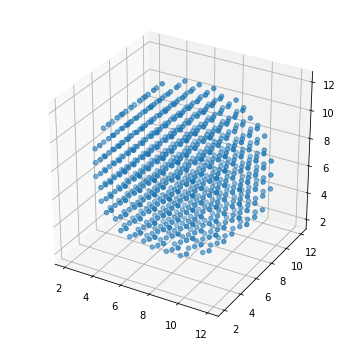

In [11]:
create_3d(use)
gc.collect()

In [13]:
@jit(float64[:,:,:](float64[:,:,:], float64[:,:,:], float64))
def get_delta(griddata, use, vol):
    numpts = ndimage.convolve(griddata, use, mode='wrap')/vol
    delta = numpts/np.mean(numpts) - 1.
    gc.collect()
    return delta

In [14]:
delta10 = get_delta(griddata, use, vol[0])

In [25]:
#np.savez_compressed('../densitygrid/d10_1200g', d10_1200g = delta10)

0.1107735832266945

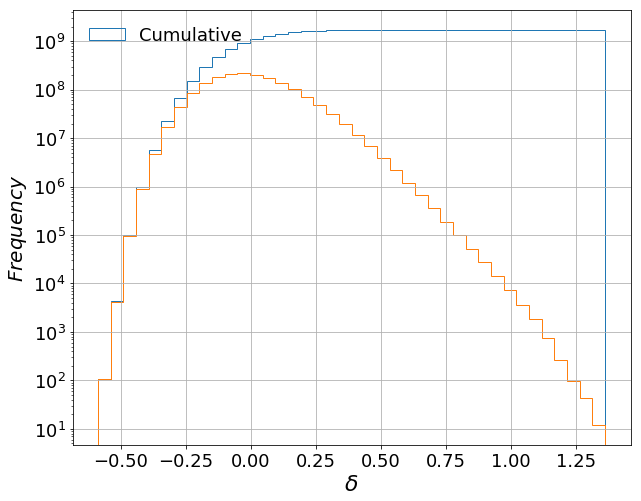

In [16]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10,8), sharex=False, 
                        sharey=False, facecolor='w', edgecolor='k')
x_coord = delta10.flatten()
axs.hist(x_coord, bins = 40, histtype='step', cumulative=True, label='Cumulative')
axs.hist(x_coord, bins = 40, histtype='step')
axs.set_yscale('log')
axs.grid(True)
axs.legend(loc='upper left', fontsize = 18, frameon = False)
axs.set_xlabel(r'$\delta$', fontsize = 22)
axs.set_ylabel(r'$Frequency$', fontsize = 20)
for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(18)
plt.show()

## To get specific coordinates of the density region, get the position and use get_coords  

All coordinates are in h less units. Maybe use view_region.ipynb to see how the region looks like

The underdense regions $\delta \le 0.$ These are of not much interest at the moment. May visit later

In [ ]:
dl0 = np.where(delta10<=0.)
coordsdl0 = get_coords(dl0)

$\delta \ge$ 1.2: Highest density regions in the box in our smoothing scale. Some of the regions overlap, since the overdensity peaks tend to cluster together. By resimulating regions that overlap we could possibly study if the galaxies in the overlapping region evolve in the same way or not.

Now I am selecting regions with -0.3$\le\delta \le$ 0

In [ ]:
tmp = np.where(np.logical_and(delta10 >= -0.01, delta10 <= 0.01))
tmp_coords = get_coords(tmp)

In [ ]:
underdense = pd.DataFrame({'delta': delta10[tmp], 'x': tmp_coords[:,0], 'y': tmp_coords[:,1], 'z': tmp_coords[:,2]}, index = range(len(tmp_coords)))
underdense = underdense.sort_values(by=['delta'], ascending=False).reset_index(drop=True)

In [ ]:
print(underdense.head())
print(underdense.tail())

# Now selecting only regions that do not overlap with each other

In [ ]:
selected = pd.DataFrame({'delta': underdense['delta'].iloc[0], 'x': underdense['x'].iloc[0], 'y': underdense['y'].iloc[0], 'z': underdense['z'].iloc[0]}, index = [0])

In [ ]:
for i in range(len(underdense)-1):
    
    this = np.array(underdense.iloc[i+1])[1:]
    
    if np.isscalar(selected['x']):
        
        tmp = np.array(selected)[1:]
        sep = np.sum((this-tmp)**2)**0.5
    
    else:
        
        tmp = np.array(selected)[:,1:]
        this = np.array(underdense.iloc[i+1])[1:]
        sep = np.sum((this-tmp)**2, axis = 1)**0.5
    
    if np.min(sep) > 10:
        
        selected = selected.append(underdense.iloc[i+1])
        
selected = selected.reset_index(drop=True)

In [ ]:
selected.head()